# Binding Accuracy Visualization
This notebook rebuilds the four-panel binding-accuracy plots directly from the saved `binding_accuracy_results.json` files and applies a high-quality style suitable for ACL-level figures.

In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 22,
    'figure.figsize': (18, 12),
    'figure.dpi': 220,
    'savefig.dpi': 400,
    'axes.linewidth': 1.2,
    'grid.color': '#d0d0d0',
    'grid.linestyle': '--',
    'grid.linewidth': 0.7,
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
})

rule_names = ['birth_date', 'birth_city', 'university', 'major', 'employer', 'work_city']

In [4]:
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# assume `rule_names` is defined globally

def load_layer_results(layer, base_dir=Path('../results/sae_per_layer')):
    layer_dir = base_dir / f'layer{layer}'
    results_path = layer_dir / 'binding_accuracy_results.json'
    if not results_path.exists():
        raise FileNotFoundError(f'Missing results for layer {layer}: {results_path}')
    with open(results_path) as f:
        data = json.load(f)
    return data


def plot_binding_accuracy(results, layer, save_path=None, dpi=400):
    # Reasonable defaults for ACL-style figures (double-column width)
    plt.rcParams.update({
        "font.family": "serif",
        "font.size": 13,
        "axes.titlesize": 15,
        "axes.labelsize": 14,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "legend.fontsize": 11,
    })

    fig, axes = plt.subplots(2, 2, figsize=(10, 7))

    # ---- (a) Confusion heatmap ----
    confusion = np.array(results['confusion_matrix'])
    sns.heatmap(
        confusion,
        annot=True,
        fmt='.2f',
        cmap='Blues',
        xticklabels=rule_names,
        yticklabels=[f'Slot {i}' for i in range(confusion.shape[0])],
        cbar_kws={'label': 'Fraction'},
        ax=axes[0, 0],
        vmin=0,
        vmax=1,
        square=True,
        linewidths=0.4,
        linecolor='white',
        annot_kws={'fontsize': 9}
    )
    axes[0, 0].set_title('Slot Assignment Confusion (Test-ID)')
    axes[0, 0].set_xlabel('True Rule')
    axes[0, 0].set_ylabel('Predicted Slot')
    axes[0, 0].tick_params(axis='x', rotation=30)

    # ---- (b) Global accuracy overview ----
    train_acc = results['train']['slot_binding_acc']
    ood_acc = results['test_ood']['slot_binding_acc']
    train_ans = results['train']['answer_acc']
    ood_ans = results['test_ood']['answer_acc']

    x = np.arange(2)
    width = 0.35

    axes[0, 1].bar(x - width/2, [train_acc, ood_acc], width,
                   label='Slot Binding')
    axes[0, 1].bar(x + width/2, [train_ans, ood_ans], width,
                   label='Answer')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(['Train', 'Test-OOD'])
    axes[0, 1].set_ylim(0, 1.02)
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Binding Accuracy Overview')
    axes[0, 1].legend(frameon=False)
    axes[0, 1].grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.5)

    # Helper for per-rule data
    def per_rule_data(split):
        slot_vals = [results[split]['per_rule'][rule]['slot_binding_acc'] for rule in rule_names]
        ans_vals = [results[split]['per_rule'][rule]['answer_acc'] for rule in rule_names]
        return slot_vals, ans_vals

    train_slot, train_ans = per_rule_data('train')
    ood_slot, ood_ans = per_rule_data('test_ood')

    idx = np.arange(len(rule_names))

    # ---- (c) Per-rule train ----
    axes[1, 0].bar(idx - width/2, train_slot, width, label='Slot Binding')
    axes[1, 0].bar(idx + width/2, train_ans, width, label='Answer')
    axes[1, 0].set_xticks(idx)
    axes[1, 0].set_xticklabels(rule_names, rotation=35, ha='right')
    axes[1, 0].set_ylim(0, 1.02)
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].set_title('Per-Rule Accuracy (Train)')
    axes[1, 0].grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.5)

    # ---- (d) Per-rule OOD ----
    axes[1, 1].bar(idx - width/2, ood_slot, width, label='Slot Binding')
    axes[1, 1].bar(idx + width/2, ood_ans, width, label='Answer')
    axes[1, 1].set_xticks(idx)
    axes[1, 1].set_xticklabels(rule_names, rotation=35, ha='right')
    axes[1, 1].set_ylim(0, 1.02)
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].set_title('Per-Rule Accuracy (Test-OOD)')
    axes[1, 1].grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.5)

    # Shared legend for the bottom row only (cleaner)
    axes[1, 0].legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)

    # Panel labels (a), (b), (c), (d)
    panel_labels = ['(a)', '(b)', '(c)', '(d)']
    for label, ax in zip(panel_labels, axes.flat):
        ax.text(-0.12, 1.05, label, transform=ax.transAxes,
                fontsize=14, fontweight='bold', va='bottom', ha='right')

    # Clean up spines
    for ax in axes.flat:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    fig.suptitle(f'SAE Layer {layer}: Binding Accuracy Summary', y=1.02, fontsize=16)
    fig.tight_layout(rect=[0, 0.02, 1, 0.97])

    if save_path is not None:
        fig.savefig(save_path, bbox_inches='tight', dpi=dpi)
    return fig

In [ ]:
def main():
    for i in range(12):
        layer_to_plot = i  # change to the layer you want to visualize
        results = load_layer_results(layer_to_plot)
        fig = plot_binding_accuracy(
            results,
            layer=layer_to_plot,
        save_path=Path('../results/sae_per_layer') / f'layer{layer_to_plot}' / 'binding_accuracy_notebook.png'
    )
    plt.show()
main()

Saved: plot_generalization.pdf


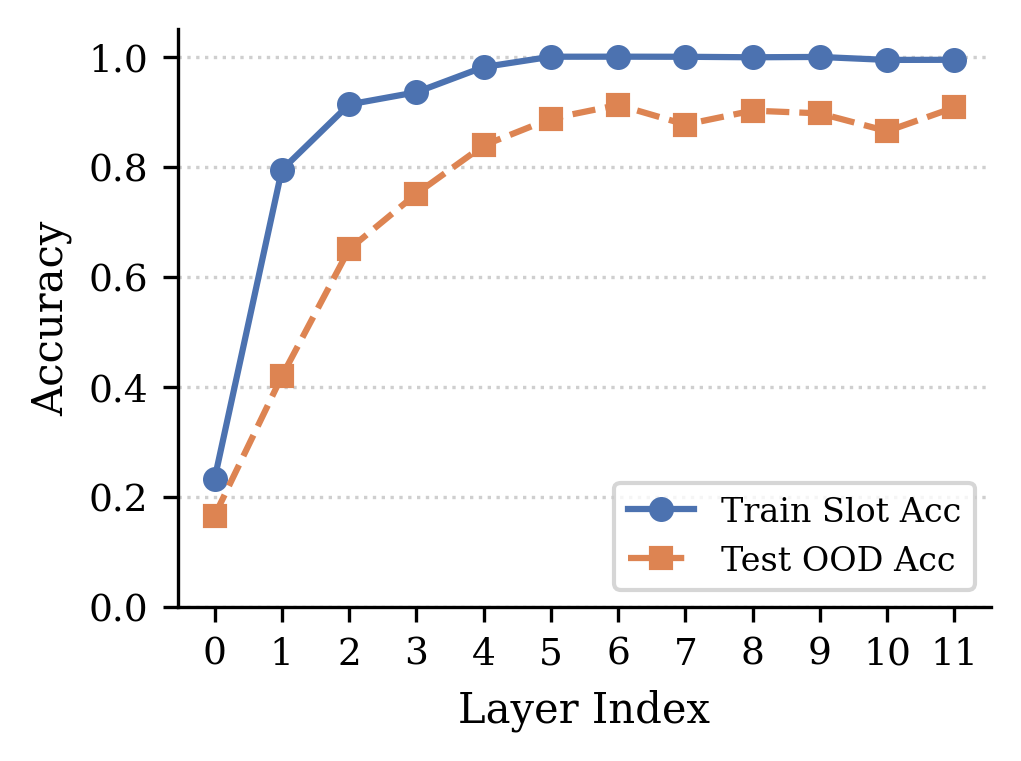

Saved: plot_mechanism.pdf


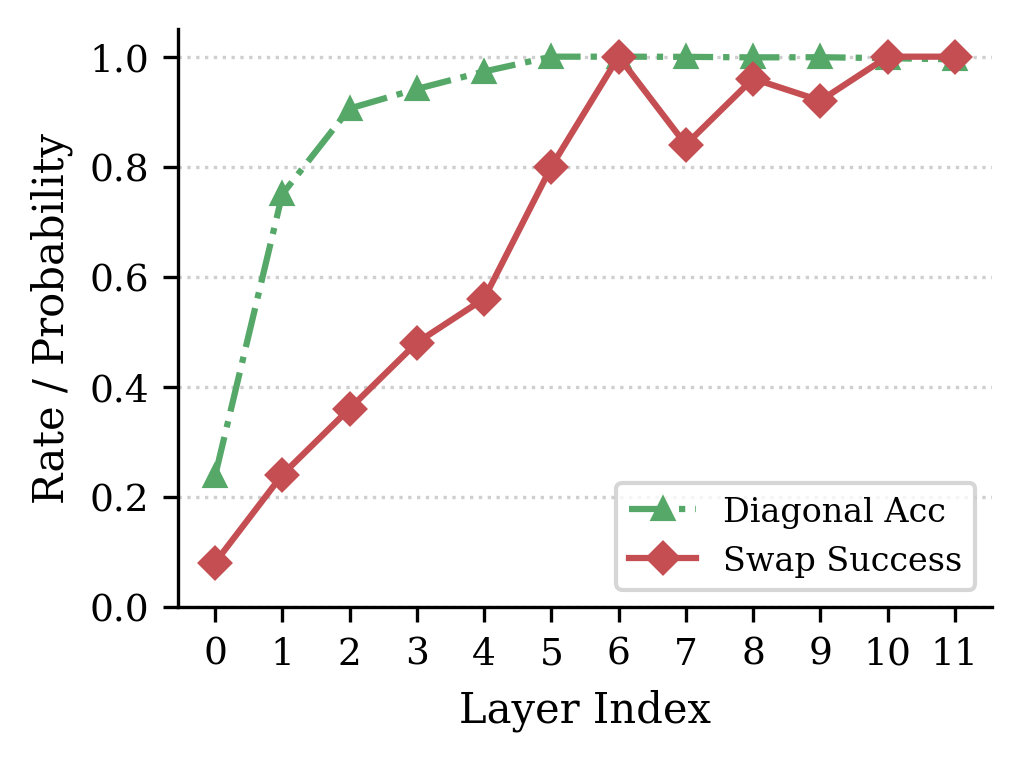

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. ACL Publication Style ---
def set_acl_style():
    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["DejaVu Serif"],
        "font.size": 10,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 8,       # Slightly smaller legend for single column
        "figure.dpi": 300,
        "lines.linewidth": 1.5,
        "lines.markersize": 5,
        "axes.spines.top": False,
        "axes.spines.right": False,
    })

# --- 2. The Data ---
layers = np.arange(12)
data = {
    "Train Slot Acc": [0.2322, 0.7941, 0.9131, 0.9353, 0.9811, 0.9999, 1.0000, 0.9998, 0.9989, 0.9995, 0.9941, 0.9943],
    "Test OOD Acc":   [0.1654, 0.4188, 0.6498, 0.7507, 0.8386, 0.8873, 0.9122, 0.8766, 0.9019, 0.8969, 0.8645, 0.9076],
    "Diagonal Acc":   [0.2377, 0.7500, 0.9057, 0.9413, 0.9730, 1.0000, 1.0000, 0.9997, 0.9987, 0.9990, 0.9973, 0.9950],
    "Swap Success":   [0.08, 0.24, 0.36, 0.48, 0.56, 0.80, 1.00, 0.84, 0.96, 0.92, 1.00, 1.00]
}
colors = sns.color_palette("deep")

# --- 3. Plot 1: Generalization (Train vs Test) ---
def plot_generalization():
    set_acl_style()
    # Size (3.5, 2.5) is perfect for one column in a two-column paper
    plt.figure(figsize=(3.5, 2.5)) 
    
    plt.plot(layers, data["Train Slot Acc"], label="Train Slot Acc", color=colors[0], marker='o', linestyle='-')
    plt.plot(layers, data["Test OOD Acc"], label="Test OOD Acc", color=colors[1], marker='s', linestyle='--')
    
    plt.xlabel("Layer Index")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1.05)
    plt.xticks(layers)
    plt.grid(axis='y', linestyle=':', alpha=0.6)
    plt.legend(loc="lower right")
    
    # Save as standalone file
    plt.savefig("plot_generalization.pdf", format="pdf", bbox_inches="tight")
    print("Saved: plot_generalization.pdf")
    plt.show()

# --- 4. Plot 2: Mechanism (Diagonal vs Swap) ---
def plot_mechanism():
    set_acl_style()
    plt.figure(figsize=(3.5, 2.5))
    
    plt.plot(layers, data["Diagonal Acc"], label="Diagonal Acc", color=colors[2], marker='^', linestyle='-.')
    plt.plot(layers, data["Swap Success"], label="Swap Success", color=colors[3], marker='D', linestyle='-')
    
    plt.xlabel("Layer Index")
    plt.ylabel("Rate / Probability")
    plt.ylim(0, 1.05)
    plt.xticks(layers)
    plt.grid(axis='y', linestyle=':', alpha=0.6)
    plt.legend(loc="lower right")
    
    # Save as standalone file
    plt.savefig("plot_mechanism.pdf", format="pdf", bbox_inches="tight")
    print("Saved: plot_mechanism.pdf")
    plt.show()

# --- Run ---
if __name__ == "__main__":
    plot_generalization()
    plot_mechanism()